In [1]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지
import yfinance as yf

## Data Load

In [12]:
tickers = ["TUA", "IEF"]

# 여러 티커의 데이터 다운로드
dataset = yf.download(tickers, ignore_tz = True, auto_adjust=True)
dataset = dataset['Close']

[*********************100%%**********************]  2 of 2 completed


In [13]:
tt = dataset.dropna()

<Axes: xlabel='Date'>

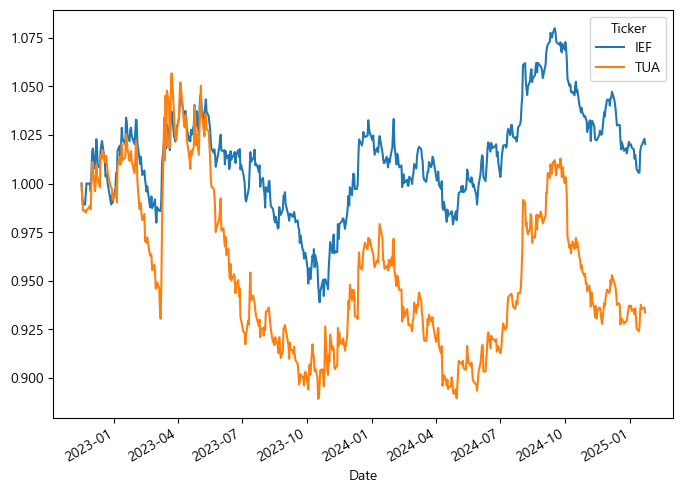

In [14]:
(tt/tt.iloc[0]).plot()

In [10]:
## dataset.to_excel('dataset.xlsx')

## Visualization

### Trend

<Axes: xlabel='Date'>

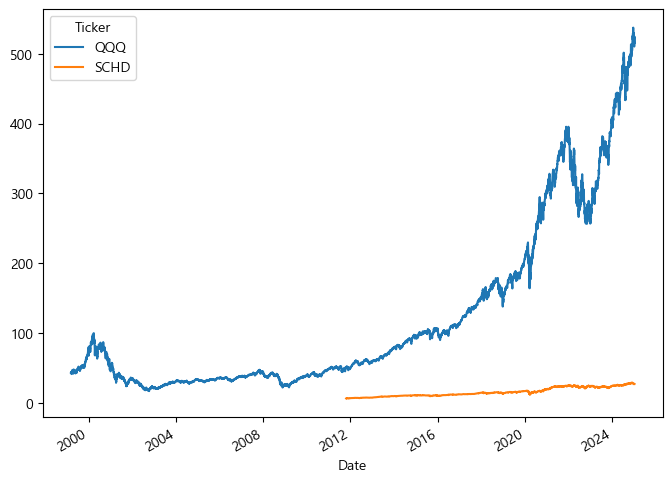

In [11]:
dataset.plot()

In [12]:
## 결측 구간 제거
dataset = dataset.dropna()

<Axes: xlabel='Date'>

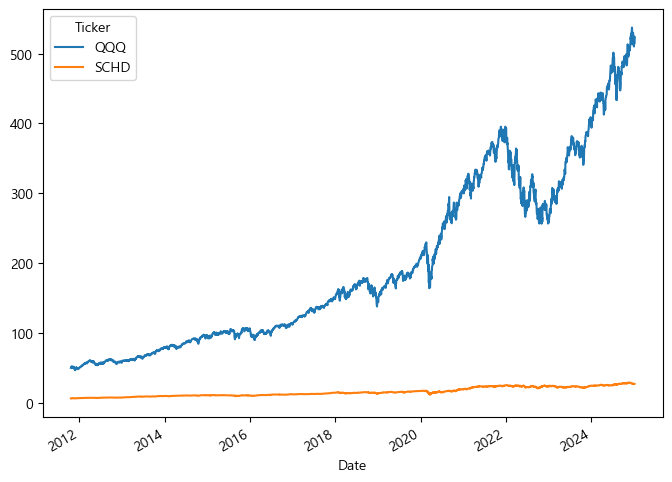

In [13]:
dataset.plot()

In [14]:
# 스케일 조정
dataset_scaled = (dataset/dataset.iloc[0])*100

<Axes: xlabel='Date'>

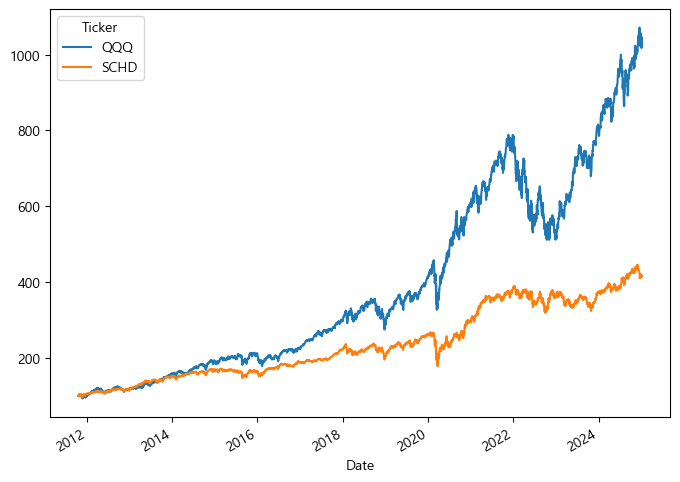

In [15]:
dataset_scaled.plot()

## Volatility

<Axes: ylabel='Count'>

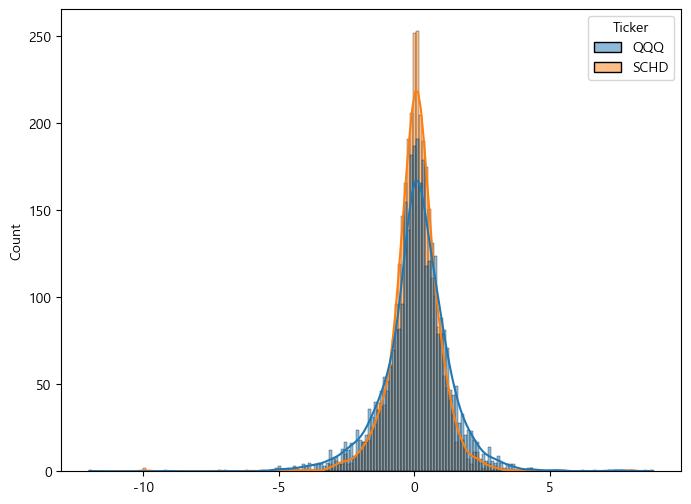

In [17]:
rets = dataset_scaled.pct_change()*100
sns.histplot(rets, kde=True)

In [18]:
peak = dataset_scaled.expanding(min_periods=1).max()

<Axes: xlabel='Date'>

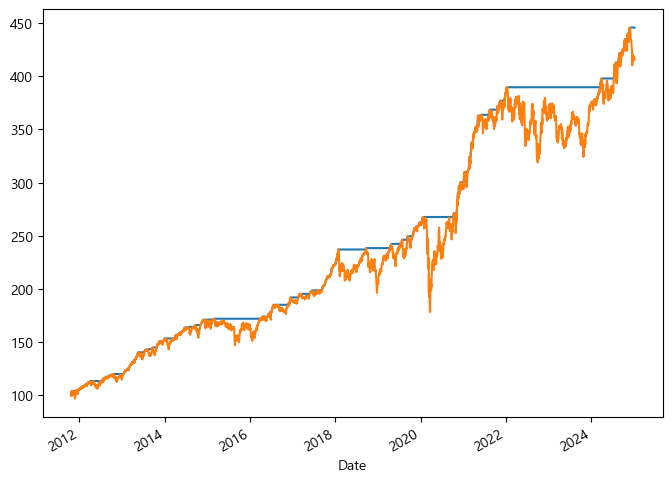

In [19]:
peak['SCHD'].plot()
dataset_scaled['SCHD'].plot()

<Axes: xlabel='Date'>

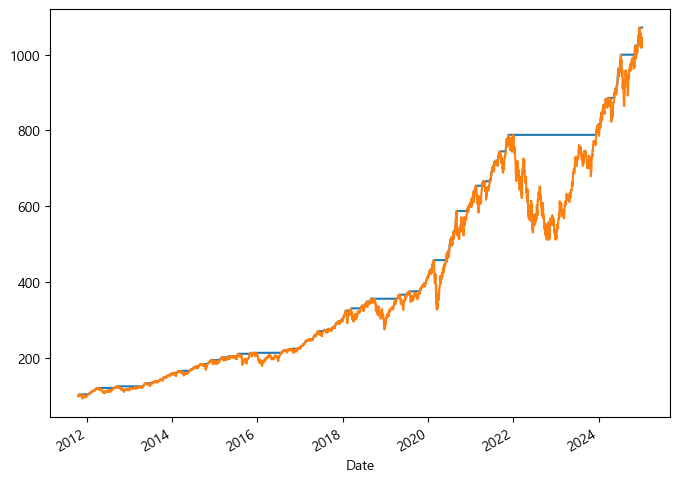

In [20]:
peak['QQQ'].plot()
dataset_scaled['QQQ'].plot()

In [21]:
drawdown = ((dataset_scaled - peak) / peak)*100

<Axes: xlabel='Date'>

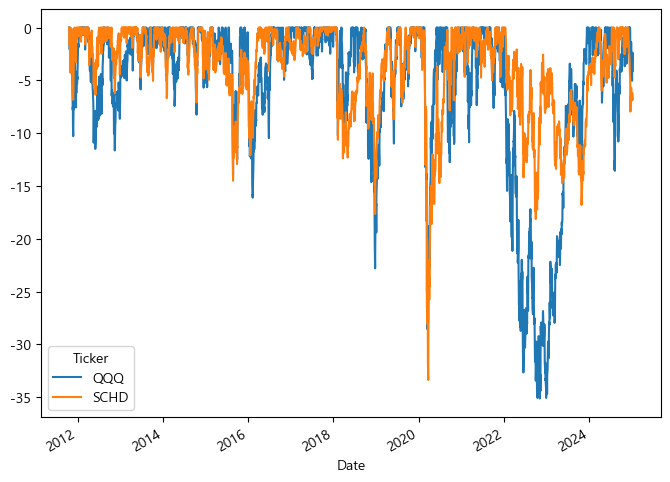

In [22]:
drawdown.plot()

In [23]:
drawdown.min()

Ticker
QQQ    -35.118726
SCHD   -33.367073
dtype: float64

In [25]:
def calculate_ttr_series(drawdown_series):
    ttr_data = []
    ttr_index = []
    in_drawdown = False
    start_date = None

    for date, value in drawdown_series.items():
        if value < 0 and not in_drawdown:
            # Start of a drawdown
            in_drawdown = True
            start_date = date
        elif value == 0 and in_drawdown:
            # Recovery point
            in_drawdown = False
            ttr_data.append((date - start_date).days)  # TTR in days
            ttr_index.append(date)

    return pd.Series(ttr_data, index=ttr_index)

ttr_dict = {}
for asset in drawdown.columns:
    # Calculate TTR
    ttr_dict[asset] = calculate_ttr_series(drawdown[asset])
ttr = pd.DataFrame(ttr_dict).interpolate(method='time')   

<Axes: >

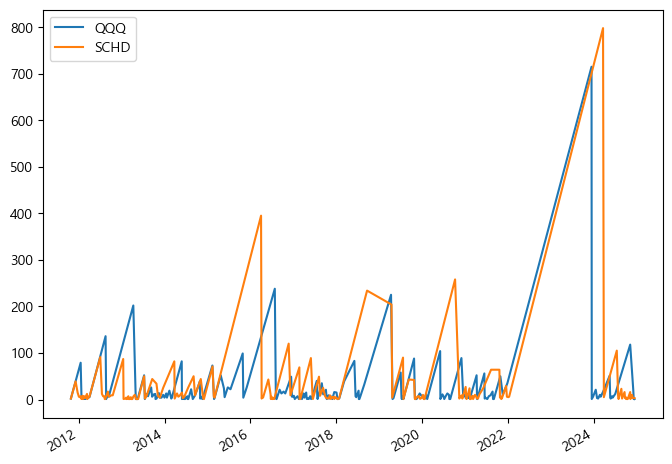

In [26]:
ttr.plot()

In [27]:
def split_time_series(df, n_days):
    split_days = n_days
    dfs = []
    for i in range(len(df)-split_days+1):
        dfs.append(df[i:split_days+i])
    return dfs

In [28]:
data = dataset_scaled
data = data.resample('M').last()
dfs = split_time_series(data, 12*5)

In [29]:
## calculate Rolling Returns
_ls = []
_idx = []
for _df in dfs:
    __ls = []
    for col in _df.columns:
        total_err = (_df[col][-1]-_df[col][0])/_df[col][0]
        yrr = (1+total_err)**(12/len(_df))-1
        __ls.append(yrr)
    _ls.append(__ls)
    _idx.append(_df.index[0])  
res = pd.DataFrame(_ls, columns = _df.columns, index=_idx)

<Axes: >

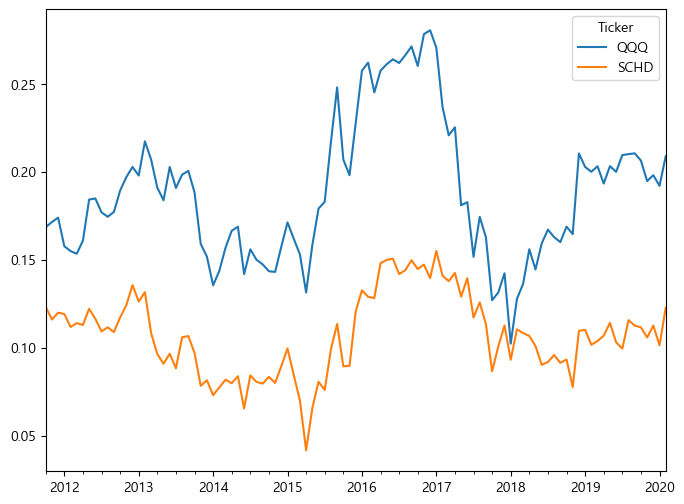

In [30]:
res.plot()

<Axes: >

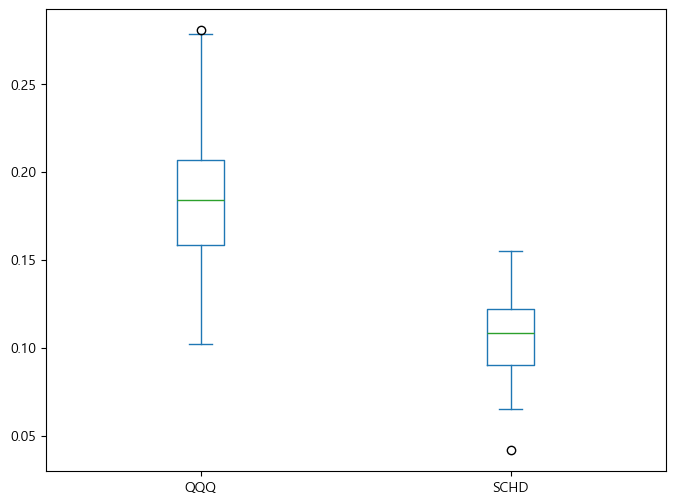

In [31]:
res.plot(kind='box')

In [32]:
dataset_scaled.pct_change().corr()

Ticker,QQQ,SCHD
Ticker,,
QQQ,1.000000,0.749836
SCHD,0.749836,1.000000
